In [1]:
#import all required modules
from idbmiot import IDBMIOT
import pandas as pd
import numpy as np
from resampling import resample
from chooseSample import chooseSample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import math
from sklearn.cross_validation import KFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt 


/home/prasad/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/prasad/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/prasad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umat

In [3]:
# import dataset
loc = "data/column_2C.csv"
df = pd.read_csv(loc, sep=',', header=None)
columns = ['pelvic_incidence','pelvic_tilt','lumbar_lordosis_angle','sacral_slope','pelvic_radius','grade_of_spondylolisthesis','Class']
df.columns = columns


S = df


class AttributeIndicator(object):
    def __init__(self):
        self.nominal = [6]
        self.numeric = [0,1,2,3,4,5]

A = AttributeIndicator()

k1 = 4
k2 = 9

print("Total Data size: " + str(len(S)))


Total Data size: 310


In [4]:
df.head(3)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,Class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB


In [5]:
 c = pd.Series.sort_values(S['Class'].value_counts())

In [6]:
c

NO    100
AB    210
Name: Class, dtype: int64

In [7]:
beforeTimeInMillis = int(round(time.time() * 1000))

#Perform oversampling
try:
    newS = IDBMIOT(S,A, k1, k2)
except Exception as error:
    print("Error Message:" + str(error))
    newS = S

afterTimeInMillis = int(round(time.time() * 1000))

excutionTime = afterTimeInMillis - beforeTimeInMillis

#Get distribution for sample original/after sampling
print ("Distribution of class labels before resampling {}".format(S['Class'].value_counts()))
print ("Distribution of class labels after resampling {}".format(newS['Class'].value_counts()))


Oversampling rate: NO    100
AB      0
Name: Class, dtype: int64


/home/prasad/Documents/project/project-algo/amdo/code/idbmiot.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  randomSample['principal component 1']  = randomSample['principal component 1'] + rs


Distribution of class labels before resampling AB    210
NO    100
Name: Class, dtype: int64
Distribution of class labels after resampling AB    210
NO    200
Name: Class, dtype: int64


In [7]:
print("BeforeTimeInMillis: (in ms): " + str(beforeTimeInMillis))
print("AfterTimeInMillis: (in ms): " + str(afterTimeInMillis))
print("Total Time spent: (in ms): " + str(excutionTime) + ", for datasize of: " + str(len(df)) )

BeforeTimeInMillis: (in ms): 1543330350886
AfterTimeInMillis: (in ms): 1543330356229
Total Time spent: (in ms): 5343, for datasize of: 310


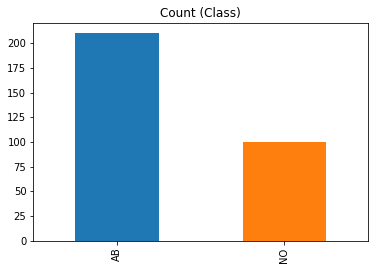

In [8]:
S.Class.value_counts().plot(kind='bar', title='Count (Class)');

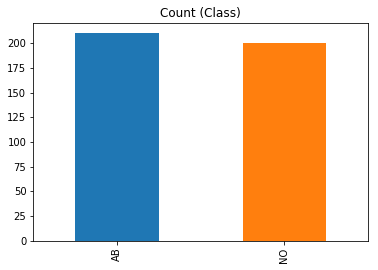

In [9]:
newS.Class.value_counts().plot(kind='bar', title='Count (Class)');

In [10]:
#difference increase
dis_new = newS.Class.value_counts()
dis_S = S.Class.value_counts()

diff = dis_new - dis_S



In [11]:
#diff
diff

AB      0
NO    100
Name: Class, dtype: int64

In [12]:
y = newS.Class

X = newS.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

y_train, y_test = np.asarray(y_train), np.asarray(y_test)

In [13]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)

clf.fit(X_train, y_train)

report = classification_report(y_test, clf.predict(X_test))

In [14]:
print(report)

             precision    recall  f1-score   support

         AB       0.90      0.70      0.79        63
         NO       0.74      0.92      0.82        60

avg / total       0.82      0.80      0.80       123



In [15]:
import matplotlib.pyplot as plt
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

[0.9, 0.7, 0.79]
[0.74, 0.92, 0.82]


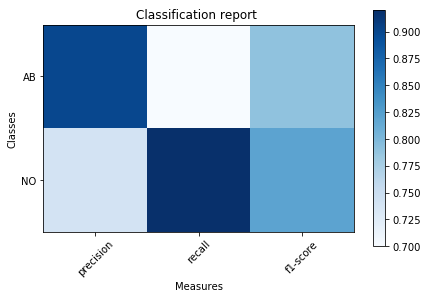

In [16]:
plot_classification_report(report)

In [17]:
score=accuracy_score(y_test, clf.predict(X_test))

In [18]:
score

0.8048780487804879